# Visualizing FastText Model

This notebook develops functions for visualizing semantic relationships preserved in a FastText model of the Sumerian corpus using t-SNE and Bokeh.

Inspired by [*LDA visualized using t-SNE and Bokeh*](https://www.kaggle.com/yohanb/lda-visualized-using-t-sne-and-bokeh) by Yohan, and [*Visualizing Word Vectors with t-SNE*](https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne) by Jeff Delayney.

Note: for visualization Bokeh is preferred over Matplotlib primarily because of the difficulties in using a custom font in Matplotlib. This becomes a major obstacle when trying to represent tokens in cuneiform.

In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
warnings.filterwarnings(action='ignore', category=FutureWarning, module='gensim' )
import gensim
import numpy as np
import pickle
from sklearn.manifold import TSNE
from gensim.models.fasttext import FastText as FT_gensim
import pandas as pd
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import ColumnDataSource, LabelSet, Legend, LegendItem #, HoverTool, CustomJS, , Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
output_notebook()
# note: more recent bokeh versions require notebook 5 or JupyterLab

Loading BokehJS ...

# Load the Models
There are three models: 
- model_cuneiform.model: the Sumerian copus in Unicode cuneiform
- model_tl.model: the Sumerian corpus in transliteration
- model_lemm.model: the Sumerian corpus in lemmatization

In [2]:
model_c = FT_gensim.load("model/model_cuneiform.model")
model_l = FT_gensim.load("model/model_lemm.model")
model_t = FT_gensim.load("model/model_tl.model")

# Cuneify
Create a function that allows input in transliteration, with output in cuneiform.

In [3]:
with open("output/ogsl.p", "rb") as p:
    o = pd.read_pickle(p)
signs_d = dict(zip(o["value"], o["utf8"]))

In [4]:
def cun(text): 
    """transform transliterated input into cuneiform. Use unicode subscript numbers and separate all signs with hyphens; separate words with blanks
    Examples: 'ma-an-gi₄'; 'd-en-lil₂ nibru-ki'.
    Transliteration style (sugal₇ vs. sukkal; dug₄ vs. du₁₁; gen vs. ŋen; etc.) and capitalization are unimportant.
    """
    cun_line = []
    words = text.lower().split()
    for word in words: 
        signs = word.lower().split('-')
        seq = [signs_d[s] if s in signs_d else s for s in signs]
        seq = ''.join(seq)
        cun_line.append(seq)
    line = ' '.join(cun_line)
    return(line)

# Create Lists of Semantically Related Words

In [ ]:
def word_categories(model, words, topn=10):
    """word_categories takes an iterable with one or more words from the vocabulary of model.
    For each word a dictionary of similar words (with the target word) is construed.
    The value of each word is numerical (integer) and indicates the category to which it belongs.
    The function returns a dictionary."""
    word_d = {}
    for idx, word in enumerate(words):
        w = model.wv.most_similar(word, topn=topn)
        w = [m[0] for m in w]
        w.append(word)
        for item in w:
            if item in word_d:
                word_d[item] = 5
            else:
                word_d[item] = idx
    return word_d

# Project and Visualize Related Words

In [ ]:
def tsne_bokeh(model, word_d, words, fontsize="12pt"):

    labels = []
    tokens = []
    categories = []
    legend = []
    
    for word in word_d:
        tokens.append(model.wv[word])
        labels.append(word)
        categories.append(word_d[word])
        if word_d[word] == 5: 
            legend.append("mixed")
        else: 
            legend.append(words[word_d[word]])
    
    color_d = {0: "black", 1: "red", 2: "green", 3: "yellow", 4: "brown", 5: "blue"}
    colors = [color_d[category] for category in categories]
    
    tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    tsne_embedding = tsne.fit_transform(tokens)
    tsne_embedding = pd.DataFrame(tsne_embedding, columns=['x','y'])
    tsne_embedding["color"] = colors
    tsne_embedding["labels"] = labels
    tsne_embedding["legend"] = legend

    source = ColumnDataSource(
        data=dict(
        x = tsne_embedding.x,
        y = tsne_embedding.y,
        colors = tsne_embedding.color,
        labels=tsne_embedding.labels,
        legend = tsne_embedding.legend
        )
    )

    l = LabelSet(x='x', y='y', text='labels', level='glyph',
              x_offset=5, y_offset=5, source=source, render_mode='canvas', 
             text_font_size=fontsize, text_font="CuneiformComposite")

    plot_tsne = figure(plot_width=900, plot_height=900) #, tools=tools_tsne, title='Papers')
    plot_tsne.circle('x', 'y', size=7, fill_color='colors', 
                  line_alpha=0, line_width=0.01, source=source, legend="legend")
    plot_tsne.add_layout(l)
    plot_tsne.legend.border_line_width = 3
    plot_tsne.legend.border_line_color = "black"
    plot_tsne.legend.border_line_alpha = 1
    plot_tsne.legend.location = "top_right"
    plot_tsne.legend.background_fill_color = "beige"
    plot_tsne.legend.background_fill_alpha = 0.5
    return plot_tsne

In [ ]:
output_file("graphs/vegetables_perfumes.html")
vegetables_perfumes = [cun("šim-gig"), cun("hi-sar")]
words_d = word_categories(model_c, vegetables_perfumes, 10)
p2 = tsne_bokeh(model_c, words_d, vegetables_perfumes, "30pt")
save(p2)
show(p2)

In [ ]:
central_bureau = [cun("na-sa₆"), cun("ab-ba-sa₆-ga"), cun("in-ta-e₃-a")]
c_b = word_categories(model_c, central_bureau, 20)
p1 = tsne_bokeh(model_c, c_b, central_bureau, "20pt")
save(p1)
show(p1)

In [ ]:
output_file("graphs/vegetables_perfumes_l.html")
vegetables_perfumes = ["šimgig[tree]N", "hiz[vegetable]N"]
words_d = word_categories(model_l, vegetables_perfumes, 35)
p2 = tsne_bokeh(model_l, words_d, vegetables_perfumes, "12pt")
save(p2)
show(p2)

In [ ]:
model_c.wv.most_similar(cun("ab-ba-sa₆-ga"), topn = 20)

In [36]:
naramili = cun("na-ra-am-i₃-li₂")

In [37]:
model_c.wv.most_similar(naramili)

[('𒋗𒆏𒁕', 0.9129834771156311),
 ('𒋗𒀭𒅘𒋫', 0.9104877710342407),
 ('𒋗𒀭𒆏𒁕', 0.8739895224571228),
 ('𒉌𒃮𒅗', 0.8698017597198486),
 ('𒀀𒍪', 0.8612921237945557),
 ('𒈨𒀭𒅗𒁲', 0.8588619232177734),
 ('𒀀𒉈𒀀', 0.8588420152664185),
 ('𒂍𒀀𒊬', 0.853057861328125),
 ('𒋗𒆏𒋫', 0.8526027202606201),
 ('𒈾𒉿𒅕𒀭', 0.8515530824661255)]

In [ ]:
model_c.wv.most_similar(cun("lugal-iti-da"))

In [ ]:
babati_abbasaga = [cun("ba-ba-ti"), cun("ab-ba-sa₆-ga")]
words_d = word_categories(model_c, babati_abbasaga, 10)
p2 = tsne_bokeh(model_c, words_d, babati_abbasaga, "20pt")
show(p2)

In [13]:
p_d = ["ab-ba-sa₆-ga", "u₂-ta₂-mi-šar-ra-am", "a-hu-we-er", "tu-ra-am-d-da-gan"]

In [34]:
p_d = ["šu-{d}idim", "šu-kab-ta", "šu-{d}kab₂-ta₂", "šu-{d}kab-ta₂"]

In [35]:
for item in p_d: 
    print(item in model_t.wv.vocab)

True
True
False
True


In [25]:
pd = [model_c.wv[p] for p in p_d]

In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

In [21]:
Z = linkage(pd, 'ward')

In [ ]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [ ]:
c, coph_dists = cophenet(Z, pdist(pd))
c

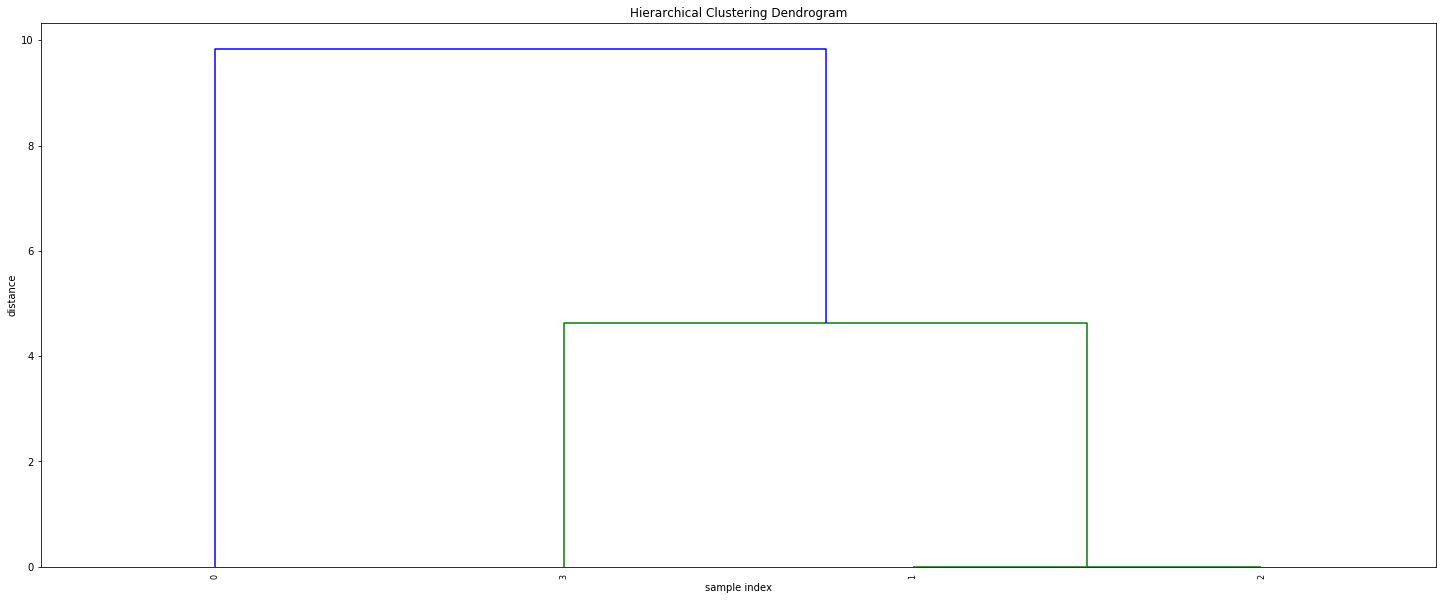

In [22]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [48]:
def dendro(model, word, topn=10): 
    words = model.wv.most_similar(word, topn = topn)
    words = [w[0] for w in words]
    words.append(word)
    vectors = [model.wv[p] for p in words]
    l = linkage(vectors, method='complete', metric='seuclidean')

# calculate full dendrogram
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.ylabel('word')
    plt.xlabel('distance')

    dendrogram(
        l,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=16.,  # font size for the x axis labels
        leaf_label_func=lambda v: str(words[v])
        )
    plt.show()

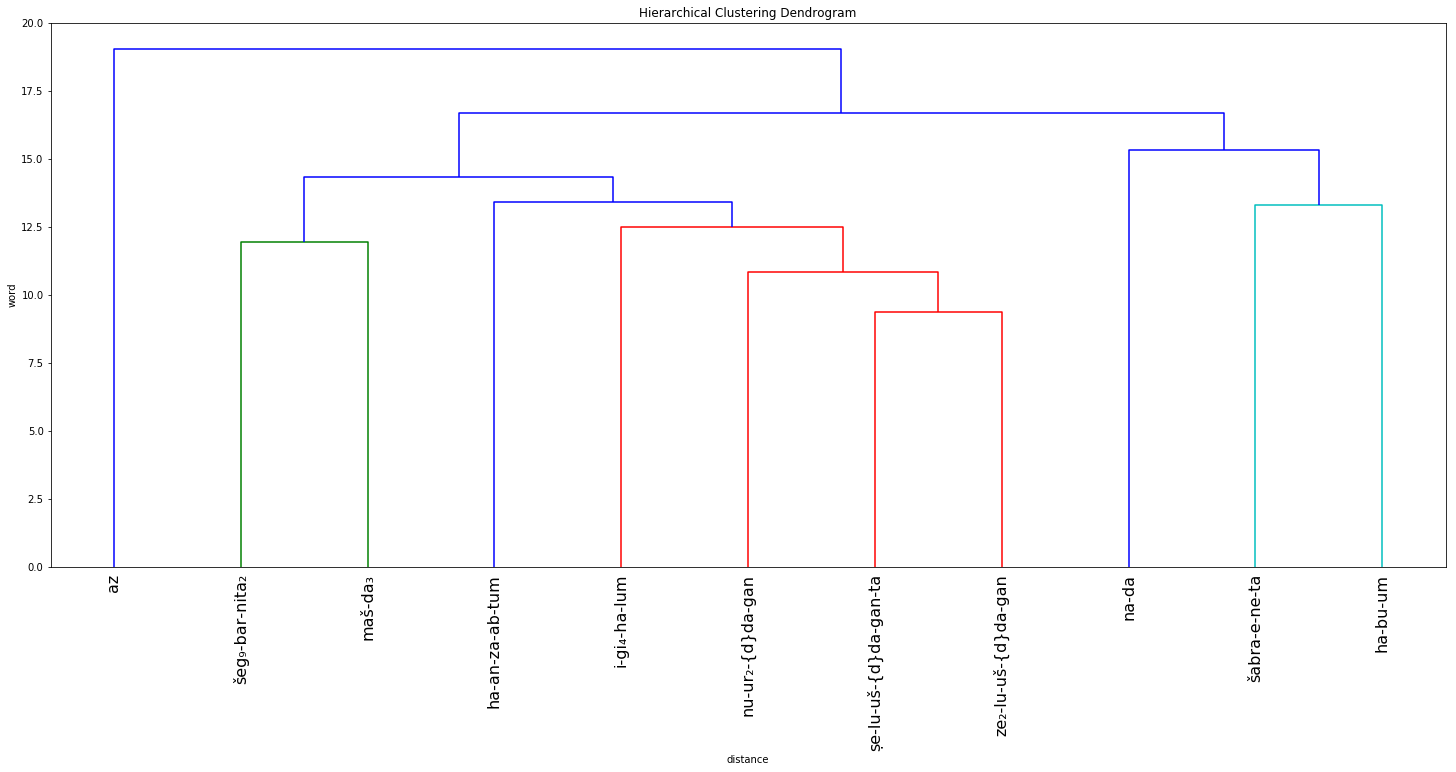

In [51]:
dendro(model_t, "ha-bu-um")

In [39]:
s = model_t.wv.most_similar("na-ra-am-i₃-li₂")

In [40]:
s = [n[0] for n in s]

In [42]:
s.append("na-ra-am-i₃-li₂")